In [329]:
# pip install xgboost
# pip install hyperopt
#https://hyperopt.github.io/hyperopt/?source=post_page
# pip install category_encoders
# pip install scikit-optimize
# pip install dtreeviz


**Install Libraries**

In [330]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb


import shap

from xgboost import plot_importance
from xgboost import XGBRegressor, plot_importance, plot_tree, plotting


import dtreeviz
import graphviz



from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder



# #for hyperparameter tuning
# import hyperopt
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler




**Load dataset (football_cleaned_supervised.csv)**

In [331]:
def load_dataset(data):
    df = pd.read_csv(data)
   
    return df


In [332]:
df_football= load_dataset('cleaned_files/football_clean_supervised.csv')

In [333]:
df_football.head(3)

Unnamed: 0           NAME  GRADE       AGE  SKILL STARCOLL  NUMOFF  POS  \
0           0   Arch Manning    2.0  18.28281  99.53    Texas    18.0  1.0   
1           1   Anthony Hill    2.0  18.00000  97.87    Texas    25.0  8.0   
2           2  CJ Baxter Jr.    2.0  18.00000  97.26    Texas    25.0  9.0   

   HEIGHT_IN  WEIGHT_LBS  ...  TIK_LONG  TOT_FOL     SPORT  RECRUIT_YEAR  \
0       75.5       220.0  ...    8900.0  73900.0  football        2023.0   
1       73.5       225.0  ...       0.0  13100.0  football        2023.0   
2       73.0       216.0  ...    1700.0  10900.0  football        2023.0   

   EXP_MONTHS  EXP_YEARS institution_name_short  ClassificationCode  \
0         2.0   0.189041                  Texas                 1.0   
1         2.0   0.189041                  Texas                 1.0   
2         2.0   0.189041                  Texas                 1.0   

       REV_MEN     EXP_MEN  
0  161532860.0  50633156.0  
1  161532860.0  50633156.0  
2  161532860.0  50633156.0  

[3 rows x 24 columns]

In [334]:
#save athlete names for later indexing
athlete_names = df_football['NAME']
# athlete_names

#remove Unnamed:0 and Sport column- not necessary 
def drop_col(df):
    df=df.drop(columns=['Unnamed: 0', 'NAME', 'STARCOLL', 'institution_name_short','SPORT'])
    return df

In [335]:
df_football = drop_col(df_football)



In [336]:
# # df_football.isna().sum()
df_football.columns
# df_football.info()

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'EXP_YEARS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

**Extract target and features. Perform Train-Test Split**

In [337]:

# Extract target and features
Target = 'NILVAL_LONG_USD'
Predictors = ['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'EXP_YEARS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN']

X = df_football.drop('NILVAL_LONG_USD', axis=1).values
y =  df_football[['NILVAL_LONG_USD']].values
# X.head(3)

In [338]:
#split the data
#Shuffle data given concern that dataset has athletes ordered by SKILL (but also look at skew later based on model performance)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)
print(X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1010, 18) (1010, 1)
(253, 18) (253, 1)


**XGBoostRegressor Base Model Decision Trees as Base Learners- using all features- using scikit learn**

In [339]:
#using default parameters, boosting rounds = 5  objective =reg:squarederror  XGBoost default is gbtree
xg_reg2 = XGBRegressor(n_estimators=5, random_state= 42)
xg_reg2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=5, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=42, reg_alpha=0, ...)

RMSE: 107217.793403
Train R2 Value: 0.7787083119471852
Accuracy Test 28.74182468572512


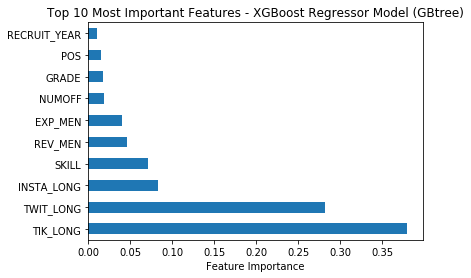

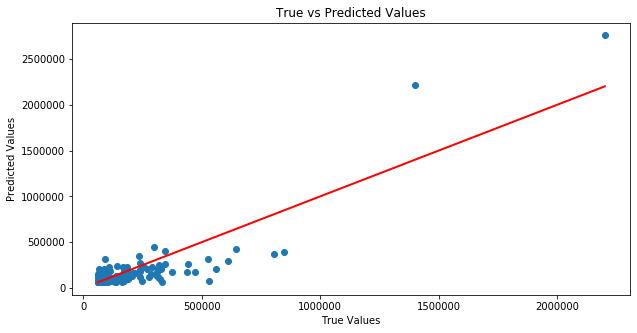

In [340]:
# Predict the labels of the test set: preds
preds = xg_reg2.predict(X_test)

# compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

 
#Measuring Goodness of fit in Training data
from sklearn import metrics
print('Train R2 Value:',metrics.r2_score(y_train, xg_reg2.predict(X_train)))
 
#Measuring accuracy on Testing Data
print('Accuracy Test',100- (np.mean(np.abs((y_test - preds) / y_test)) * 100))



#Plotting the feature importance for Top 10 most important columns
%matplotlib inline
feature_importances = pd.Series(xg_reg2.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')
plt.xlabel ("Feature Importance")
plt.title("Top 10 Most Important Features - XGBoost Regressor Model (GBtree)")
 
#Printing some sample values of prediction
TestingDataResults=pd.DataFrame(data=X_test, columns=Predictors)
TestingDataResults[Target]=y_test
TestingDataResults[('Predicted'+Target)]=preds
TestingDataResults.head()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_test, preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()


In [341]:
# metrics.classification_report(y_test, pred)

In [342]:
# https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_xgboost_visualisations.ipynb

#initialize dtreevizmodel (adaptor)

viz_rmodel = dtreeviz.model(model=xg_reg2, tree_index=1, 
                            X_train=df_football[Predictors],
                            y_train=df_football[Target], 
                            feature_names=Predictors, 
                            target_name=Target)

In [343]:
#Tree structure visualizations

# viz_rmodel.view()
viz_rmodel.view(orientation="LR")

C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Py

In [344]:
#Prediction path explanations
x = df_football[Predictors].iloc[10]
x
viz_rmodel.view(x=x)

C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Py

C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars


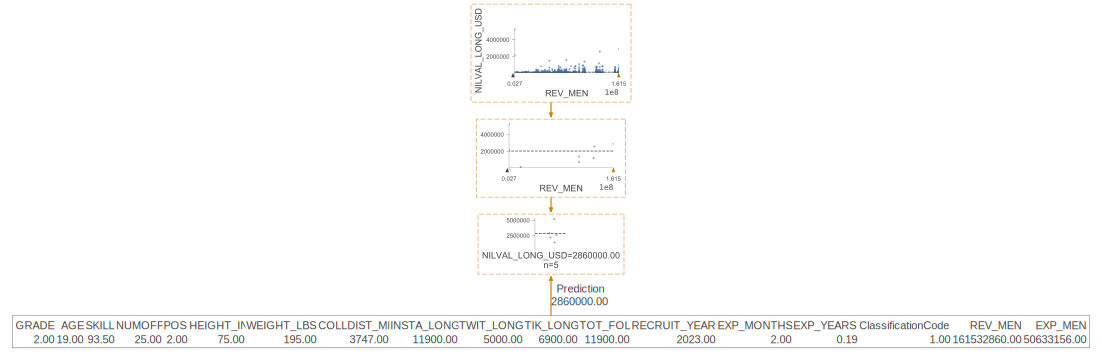

In [345]:
viz_rmodel.view(show_just_path=True, x = x)

In [346]:
print(viz_rmodel.explain_prediction_path(x))

53500.0 <= REV_MEN 



In [347]:
# viz_rmodel.plot_importance(x, figsize=(3.5,2))

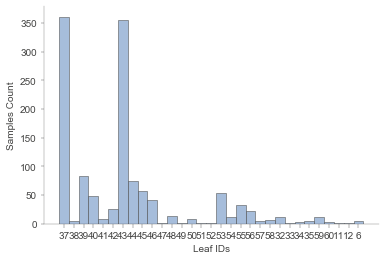

In [348]:
#leaf ratios
viz_rmodel.leaf_sizes()

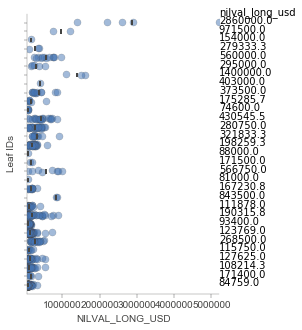

In [349]:
viz_rmodel.rtree_leaf_distributions()

In [350]:
viz_rmodel.node_stats(node_id=4)

GRADE         AGE       SKILL      NUMOFF         POS   HEIGHT_IN  \
count  168.000000  168.000000  168.000000  168.000000  168.000000  168.000000   
mean     2.404762   18.476069   97.503750   23.303571    4.720238   74.550595   
std      2.024515    1.359121    0.928975    4.175433    2.976808    2.225761   
min      0.000000   16.000000   96.110000    1.000000    1.000000   68.500000   
25%      0.000000   17.000000   96.705000   24.000000    2.000000   73.000000   
50%      2.000000   19.000000   97.335000   25.000000    4.000000   75.000000   
75%      4.000000   20.000000   98.290000   25.000000    7.000000   76.500000   
max      6.000000   21.000000   99.590000   25.000000   15.000000   79.000000   

       WEIGHT_LBS  COLLDIST_MI    INSTA_LONG     TWIT_LONG      TIK_LONG  \
count  168.000000   168.000000  1.680000e+02    168.000000  1.680000e+02   
mean   227.010714   410.196429  3.000665e+04   9029.761905  2.097689e+04   
std     47.841832   445.936829  1.646255e+05   6752.906312  1.633321e+05   
min    155.000000     0.000000  1.600000e+03   1500.000000  0.000000e+00   
25%    185.750000   110.250000  5.594500e+03   4400.000000  0.000000e+00   
50%    215.000000   234.500000  9.150000e+03   7000.000000  5.930000e+02   
75%    261.500000   524.250000  1.772500e+04  12625.000000  4.825000e+03   
max    350.000000  2020.000000  2.122000e+06  52000.000000  2.100000e+06   

            TOT_FOL  RECRUIT_YEAR  EXP_MONTHS   EXP_YEARS  ClassificationCode  \
count  1.680000e+02    168.000000  168.000000  168.000000               168.0   
mean   3.000665e+04   2022.732143    8.880952    0.756327                 1.0   
std    1.646255e+05      1.201163    9.916302    0.831920                 0.0   
min    1.600000e+03   2021.000000    0.000000    0.000000                 1.0   
25%    5.594500e+03   2022.000000    0.000000    0.000000                 1.0   
50%    9.150000e+03   2023.000000    2.000000    0.189041                 1.0   
75%    1.772500e+04   2024.000000   14.000000    1.189041                 1.0   
max    2.122000e+06   2025.000000   26.000000    2.189041                 1.0   

            REV_MEN       EXP_MEN  
count  1.680000e+02  1.680000e+02  
mean   1.091515e+08  5.866933e+07  
std    3.289373e+07  1.243052e+07  
min    3.584978e+07  2.553622e+07  
25%    8.154575e+07  5.053928e+07  
50%    1.091761e+08  6.089418e+07  
75%    1.285531e+08  6.912791e+07  
max    1.615329e+08  7.500597e+07

**XGBoost with linear learner base model (GBlinear)**- Have to use XGBoot non scikit learn functions to build model

[0]	train-rmse:224203.62085	test-rmse:157862.65838
[1]	train-rmse:221611.27078	test-rmse:150190.67709
[2]	train-rmse:220781.46779	test-rmse:147218.17941
[3]	train-rmse:220255.48692	test-rmse:145978.51241
[4]	train-rmse:220039.52012	test-rmse:145222.69711
Evaluation Error: [0]	eval-rmse:145222.69710691523505375
RMSE 145222.694879:
Train R2 Value: 0.2092225204355349
Accuracy Test 29.855112546754185


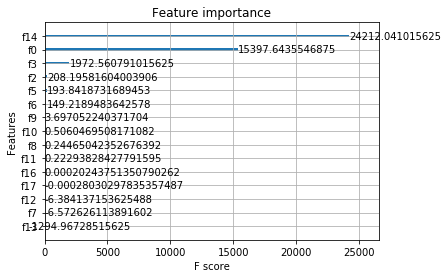

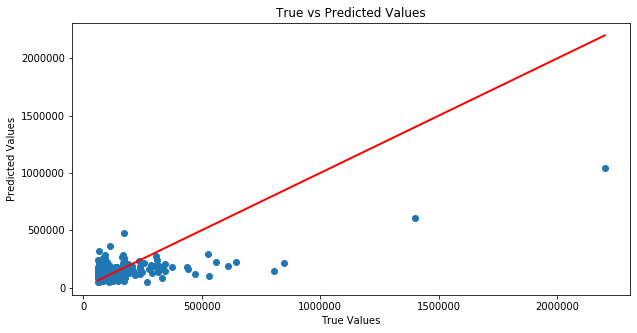

In [351]:
DM_train = xgb.DMatrix(data=X_train, label=y_train, enable_categorical= True)
DM_test = xgb.DMatrix(data=X_test, label=y_test, enable_categorical = True)


# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"}

# Define evaluation data
eval_data = [(DM_train, 'train'), (DM_test, 'test')]


# Train the model: xg_gbl
xg_gbl = xgb.train(params=params, dtrain=DM_train, evals =eval_data, num_boost_round=5)


# Predict the labels of the test set: preds
preds = xg_gbl.predict(DM_test)

# Calculate the error RMSE
error = xg_gbl.eval(DM_test)
print('Evaluation Error:', error)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
# compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE %f:" % (rmse))
#Measuring Goodness of fit in Training data
from sklearn import metrics
print('Train R2 Value:',metrics.r2_score(y_train, xg_gbl.predict(DM_train)))
#Measuring accuracy on Testing Data
print('Accuracy Test',100- (np.mean(np.abs((y_test - preds) / y_test)) * 100))


# # Plot the feature importance
from matplotlib import pyplot
# plt.figure(figsize=(10, 20))
plot_importance(xg_gbl, max_num_features = 15)
pyplot.show()



import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_test, preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()



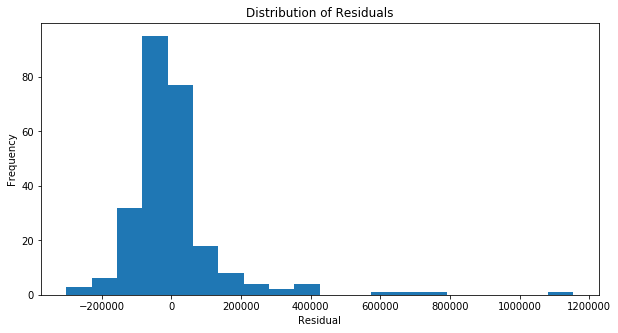

In [352]:
y_test_trans = y_test.reshape(-1)
residuals = y_test_trans - preds
residuals
# preds.shape
# # y_test.shape

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins= 20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()



In [353]:
nil_dmatrix = xgb.DMatrix(data=X, label=y)

# Perform cross-valdiation: cv_results
cv_results = xgb.cv(dtrain=nil_dmatrix, params=params, nfold=4,
                    num_boost_round=100, metrics='rmse', as_pandas=True, seed=42)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results['test-rmse-mean']).tail(1))



    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0     214541.997323    22765.811953   223667.136954   87676.507586
1     205775.900598    25076.304310   218700.139951   88288.818486
2     202928.470275    26056.204587   222440.856365   93560.478336
3     201169.601013    27016.003537   226349.286645   98668.601850
4     200243.354521    27514.153863   230420.334146  104570.252356
..              ...             ...             ...            ...
95    195206.114365    27398.319035   259140.171755  143742.727741
96    195174.862871    27383.934512   259097.679661  143695.121401
97    195144.849007    27370.854572   259178.352653  143774.143189
98    195114.267121    27356.614209   259135.542849  143690.386004
99    195088.263193    27346.184415   259137.743603  143622.486808

[100 rows x 4 columns]
99    259137.743603
Name: test-rmse-mean, dtype: float64


In [354]:
nil_dmatrix = xgb.DMatrix(data=X, label=y)

# Perform cross-valdiation: cv_results
cv_results = xgb.cv(dtrain=nil_dmatrix, params=params, nfold=4,
                    num_boost_round=100, metrics='mae', as_pandas=True, seed=42)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results['test-mae-mean']).tail(1))



    train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0     97448.645268    8552.830875  100867.868109   9973.863348
1     90797.879339    7595.785967   93968.266990  12001.178511
2     89449.328869    5143.670975   93312.948456  15257.777613
3     89194.545668    6590.605568   92768.190689  14088.576193
4     88847.491116    6602.753111   91962.074227  13066.801852
..             ...            ...            ...           ...
95    88418.714217    7298.647450   94592.362293  12841.333242
96    88438.776523    7403.985141   94614.111205  12749.306395
97    88430.435885    7326.799935   94606.851718  12831.002380
98    88590.916630    7497.436543   94737.592758  12663.054951
99    88405.185451    7314.319721   94583.293813  12857.960629

[100 rows x 4 columns]
99    94583.293813
Name: test-mae-mean, dtype: float64


In [355]:
# https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_xgboost_visualisations.ipynb

#initialize dtreevizmodel (adaptor)

# viz_rmodel = dtreeviz.model(model=xg_reg2, tree_index=0, 
#                             X_train=X, 
#                             y_train=y, 
#                             feature_names=Predictors, 
#                             target_name=Target)

**Finetune XGBoost Model- scikit learn**<br> 9 hyperparameters to address bias-variance trade-off:
<br>Iteration Control: num_boost_round; early_stopping_round
<br>Params:
<br> Shrinkage: eta
<br> Tree-Booster constraints: max_depth; min_child_weight; gamma
<br> Random Subsampling: subsample; colsample_bytree
<br> L1 & L2 regularizations: alpha; lambda
<br> Fixed paramaters: objective function for regression ;eval_metric; tree_method (hist; )


**Pre-tuning regression to compare initial performance curves of datasets along training iterations**
<br> Compare training and test performance to assess bias-variance tradeoff(problem of under/over fitting) at initial state
<br> Use for pre/post tuning performance curves comparison to assess regularization impact of tuning. Is tuning effectively performing regularization on model to assess bias-variance tradeoff?

In [356]:
Target = 'NILVAL_LONG_USD'
feature_name = ['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'EXP_YEARS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN']

X = df_football.drop('NILVAL_LONG_USD', axis=1).values
y =  df_football[['NILVAL_LONG_USD']].values



In [357]:
#params dictionary-baseline parameter to tune
# Define hyperparameters
eval_metrics = []
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0, 
    'reg_alpha': 0.1,
    'reg_lambda': 1,
     'eval_metric': ['rmse', 'mae'],
    # Other parameters-fixed
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'seed' : 42
}
num_boost_round = 1000
early_stopping_rounds = 20   #10

# Define evaluation metrics (metrics)
metrics = {'rmse', 'mae'}

seed = 42

DM_train = xgb.DMatrix(data=X_train, label=y_train, enable_categorical= True)
DM_test = xgb.DMatrix(data=X_test, label=y_test, enable_categorical = True)


def bias_variance_performance(params):
   
    evals_result = {}
    model = xgb.train(
        params,
        dtrain=DM_train,
        num_boost_round=num_boost_round,
        evals=[(DM_train, "Train"), (DM_test, "Test")],
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result,
    
    )
    train_error = evals_result["Train"]["mae"]
    test_error = evals_result["Test"]["mae"]
    train_rmse = evals_result["Train"]["rmse"]
    test_rmse = evals_result["Test"]["rmse"]
    
  
    best_mae = min(evals_result['Test']['mae'])
    best_mae_round = evals_result['Test']['mae'].index(best_mae) + 1  # Add 1 to get the round number
    
    best_rmse = min(evals_result['Test']['rmse'])
    best_rmse_round = evals_result['Test']['rmse'].index(best_rmse) + 1  # Add 1 to get the round number
    
    print("Best MAE before the Tuning: {:.4f} with {} rounds".format(best_mae, best_mae_round))
    print("Best RMSE before the Tuning: {:.4f} with {} rounds".format(best_rmse, best_rmse_round))
    
    return model, evals_result

# num_boost_round = 1000
# early_stopping_rounds = 60
pretuned_model, pre_evals_result = bias_variance_performance(params)

[0]	Train-rmse:232853.14859	Train-mae:113479.13802	Test-rmse:175423.09409	Test-mae:109687.32924
[1]	Train-rmse:188236.38862	Train-mae:82998.06064	Test-rmse:130696.31463	Test-mae:78907.75417
[2]	Train-rmse:156521.58746	Train-mae:63887.44893	Test-rmse:111222.64141	Test-mae:63926.43954
[3]	Train-rmse:133138.58573	Train-mae:52325.27323	Test-rmse:104055.01993	Test-mae:57546.19281
[4]	Train-rmse:115622.85295	Train-mae:45732.34226	Test-rmse:108887.93787	Test-mae:55535.39865
[5]	Train-rmse:102645.75298	Train-mae:42069.33371	Test-rmse:117432.47150	Test-mae:55556.62358
[6]	Train-rmse:91618.74580	Train-mae:39114.07768	Test-rmse:130246.65783	Test-mae:56257.41141
[7]	Train-rmse:83017.40219	Train-mae:36858.45652	Test-rmse:142240.13879	Test-mae:57216.41419
[8]	Train-rmse:76780.46856	Train-mae:35313.40183	Test-rmse:151868.11740	Test-mae:57636.40338
[9]	Train-rmse:70100.77134	Train-mae:33677.32701	Test-rmse:161101.04698	Test-mae:58799.28177
[10]	Train-rmse:65500.59729	Train-mae:32273.55494	Test-rmse:16

Gap for MAE for pre-tuned hyperparametes suggests overfitting
<br>**Plot performance curve for pre-tune MAE and RMSE**

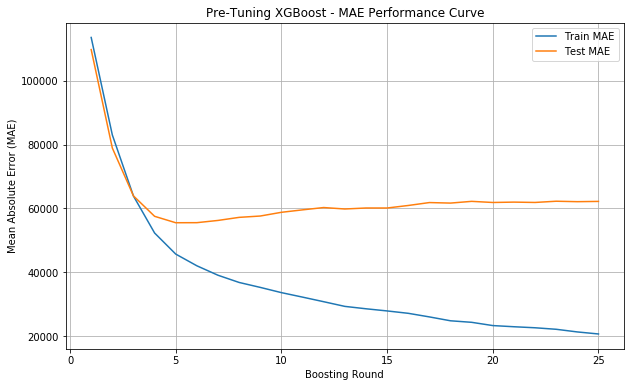

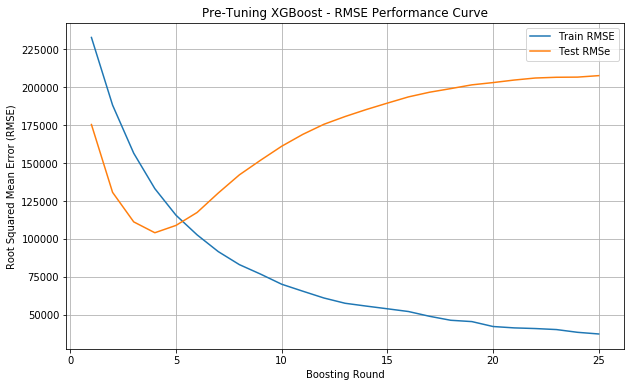

In [358]:
#Extract MAE values for both training and test sets
train_mae = pre_evals_result['Train']['mae']
test_mae = pre_evals_result['Test']['mae']


#Extract RMSE values for both training and test sets
train_rmse = pre_evals_result['Train']['rmse']
test_rmse = pre_evals_result['Test']['rmse']

# Create a plot to visualize the MAE performance curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_mae) + 1), train_mae, label='Train MAE')
plt.plot(range(1, len(test_mae) + 1), test_mae, label='Test MAE')
plt.xlabel('Boosting Round')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Pre-Tuning XGBoost - MAE Performance Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_rmse) + 1), train_rmse, label='Train RMSE')
plt.plot(range(1, len(test_rmse) + 1), test_rmse, label='Test RMSe')
plt.xlabel('Boosting Round')
plt.ylabel('Root Squared Mean Error (RMSE)')
plt.title('Pre-Tuning XGBoost - RMSE Performance Curve')
plt.legend()
plt.grid(True)

As the iterations went on, the initial (pre-tuned) training performance continued improving, while the initial (pre-tuned) test performance stagnated at some point and then started increasing. 
<b> This suggests a salient variance, or over-fitting, in the initial (pre-tuned) model

What is feature importance of model?

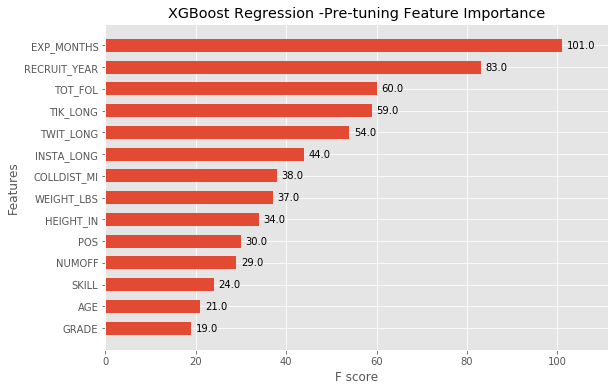

In [359]:


# Obtain the feature importance scores
importance_type = "weight"  # You can use "weight," "gain," or "cover"
importances = pretuned_model.get_score(importance_type=importance_type)

# Sort the features by importance in descending order
sorted_feature_names = sorted(importances, key=importances.get, reverse=True)

# Map sorted_feature_names to the corresponding feature names
mapped_feature_names = [feature_name[sorted_feature_names.index(name)] for name in sorted_feature_names]



mapped_feature_names
# # # Create a feature importance plot with actual feature names as y-axis labels
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111)
    xgb.plotting.plot_importance(pretuned_model, ax=ax, height=0.6, importance_type=importance_type)
    ax.set_yticklabels(mapped_feature_names)
    ax.set_title('XGBoost Regression -Pre-tuning Feature Importance')


    


**K-Cross Fold Validation**
<br> Use built in xgb.cv() function- performed only on TRAIN set

In [360]:

def perform_k_fold_cross_validation(params, DM_train, metrics, num_boost_round, early_stopping_rounds, num_folds=5):
    """
    Perform k-fold cross-validation for an XGBoost model.

    Parameters:
    - params: XGBoost hyperparameters
    - DM_train: DMatrix for the training data
    - metrics: List of evaluation metrics
    - num_boost_round: Number of boosting rounds
    - early_stopping_rounds: Early stopping criteria
    - num_folds: Number of cross-validation folds (default is 5)

    Returns:
    - cv_results: Cross-validation results as a pandas DataFrame
    """
    cv_results = xgb.cv(
        params=params,
        dtrain=DM_train,
        num_boost_round=num_boost_round,
        seed=42,  # Seed for randomization
        nfold=num_folds,
        metrics=metrics,
        early_stopping_rounds=early_stopping_rounds
    )
    return cv_results

# Call the cross_validation function
cv_results = perform_k_fold_cross_validation(params, DM_train, metrics, num_boost_round, early_stopping_rounds)


In [361]:
cv_results
best_round = cv_results['test-rmse-mean'].idxmin()
best_rmse = cv_results['test-rmse-mean'].min()
best_mae = cv_results['test-mae-mean'][best_round]

print("Best RMSE: {:.4f} at boosting round {}.".format(best_rmse, best_round))
print("Best MAE: {:.4f} at boosting round {}.".format(best_mae, best_round))

Best RMSE: 222747.5184 at boosting round 2.
Best MAE: 79857.3753 at boosting round 2.


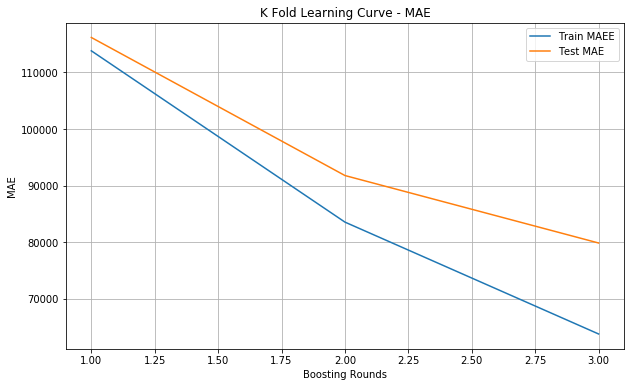

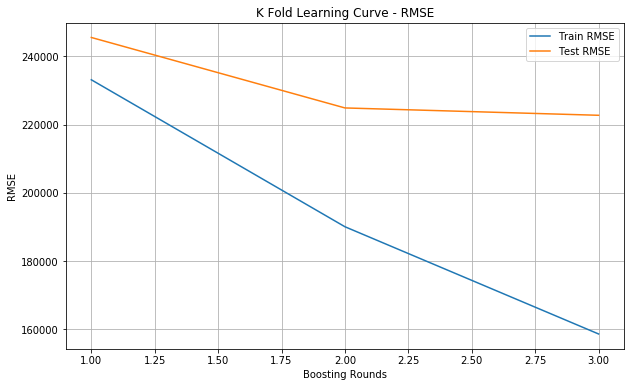

In [362]:

num_boost_rounds = len(cv_results)


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_boost_rounds + 1), cv_results['train-mae-mean'], label='Train MAEE', )
plt.plot(range(1, num_boost_rounds + 1), cv_results['test-mae-mean'], label='Test MAE', )
plt.xlabel('Boosting Rounds')
plt.ylabel('MAE')
plt.title('K Fold Learning Curve - MAE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_boost_rounds + 1), cv_results['train-rmse-mean'], label='Train RMSE', )
plt.plot(range(1, num_boost_rounds + 1), cv_results['test-rmse-mean'], label='Test RMSE', )
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('K Fold Learning Curve - RMSE')
plt.legend()
plt.grid(True)
plt.show()

**Use GridSearchCV to find best parameters**

**GridSearch for all params above takes a long time- try pairwise grid search**

In [363]:
best_score = float('inf')  # Initialize with a high value
best_params = params.copy()  # Initialize with the baseline parameters

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'eta': [0.01, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [0.1, 1, 10, 100],
    'eval_metric': ['rmse', 'mae'],
    # Other parameters-fixed
    'objective': ['reg:squarederror'],
    'tree_method': ['hist']
}

# Define sets of hyperparameters to tune as pairs
parameter_sets = [
    ('max_depth', 'eta'),
    ('min_child_weight', 'gamma'),
    ('colsample_bytree', 'subsample'),
    ('reg_alpha', 'reg_lambda')
]

for param_set in parameter_sets:
    param1, param2 = param_set

    for val1 in param_grid[param1]:
        for val2 in param_grid[param2]:
            # Create a copy of the current parameter settings
            params_copy = best_params.copy()

            # Set the values for the current pair of hyperparameters
            params_copy[param1] = val1
            params_copy[param2] = val2

            # Perform grid search using the current hyperparameters
            model, evals_result = bias_variance_performance(params_copy)
            mse = min(evals_result['Test']['mae'])  # Use an appropriate metric

            # Check if this combination of hyperparameters is better
            if mse < best_score:
                best_score = mse
                best_params[param1] = val1
                best_params[param2] = val2

print("Best Hyperparameters:", best_params)
print("Best Score (MAE):", best_score)

[0]	Train-rmse:291592.73148	Train-mae:156371.34405	Test-rmse:243097.69557	Test-mae:154541.56869
[1]	Train-rmse:289673.90053	Train-mae:154854.17845	Test-rmse:240522.35211	Test-mae:152898.00011
[2]	Train-rmse:287775.28718	Train-mae:153355.99362	Test-rmse:237987.05187	Test-mae:151262.63837
[3]	Train-rmse:285896.38158	Train-mae:151868.25154	Test-rmse:235468.00784	Test-mae:149650.64439
[4]	Train-rmse:284036.95924	Train-mae:150399.18987	Test-rmse:232988.98077	Test-mae:148046.75469
[5]	Train-rmse:282196.97409	Train-mae:148944.44518	Test-rmse:230537.92938	Test-mae:146458.30608
[6]	Train-rmse:280376.27055	Train-mae:147503.87345	Test-rmse:228114.72667	Test-mae:144885.14279
[7]	Train-rmse:278574.58636	Train-mae:146073.24294	Test-rmse:225706.84977	Test-mae:143334.64115
[8]	Train-rmse:276771.23311	Train-mae:144654.87792	Test-rmse:223352.46693	Test-mae:141826.32064
[9]	Train-rmse:275006.15819	Train-mae:143256.16003	Test-rmse:221011.35880	Test-mae:140298.35931
[10]	Train-rmse:273239.78236	Train-mae:1

In [364]:

print("Parameters after the Pair Wise Tuning")
best_params

Parameters after the Pair Wise Tuning


{'max_depth': 6,
 'min_child_weight': 4,
 'eta': 0.2,
 'subsample': 0.8,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'eval_metric': ['rmse', 'mae'],
 'objective': 'reg:squarederror',
 'tree_method': 'hist',
 'seed': 42}

In [365]:
#Now run tuned hyperparmeters (best_params) 
# num_boost_rounds = 1000
# early_stopping_rounds = 94
pw_model_1, pw_evals_result_1 = bias_variance_performance(best_params)

[0]	Train-rmse:264286.83967	Train-mae:129004.59199	Test-rmse:212877.36107	Test-mae:127331.75941
[1]	Train-rmse:242447.09282	Train-mae:106747.30899	Test-rmse:188288.28514	Test-mae:105530.85422
[2]	Train-rmse:221943.89303	Train-mae:88359.60310	Test-rmse:165536.59828	Test-mae:88188.50406
[3]	Train-rmse:202846.87926	Train-mae:74634.69150	Test-rmse:141538.43228	Test-mae:75575.03437
[4]	Train-rmse:190146.42364	Train-mae:65090.10645	Test-rmse:129258.07364	Test-mae:67268.07172
[5]	Train-rmse:175297.20592	Train-mae:58799.20178	Test-rmse:111034.28198	Test-mae:60881.38448
[6]	Train-rmse:167296.83908	Train-mae:54563.09545	Test-rmse:104772.26946	Test-mae:57646.75500
[7]	Train-rmse:158413.43043	Train-mae:51478.26446	Test-rmse:93787.59264	Test-mae:53794.85383
[8]	Train-rmse:154919.46424	Train-mae:49235.30621	Test-rmse:90035.16693	Test-mae:51611.36540
[9]	Train-rmse:149926.93908	Train-mae:48465.42964	Test-rmse:84843.63760	Test-mae:49473.47783
[10]	Train-rmse:143809.70640	Train-mae:47433.23827	Test-rms

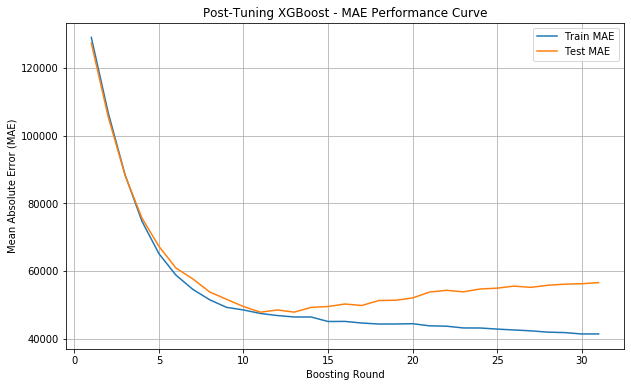

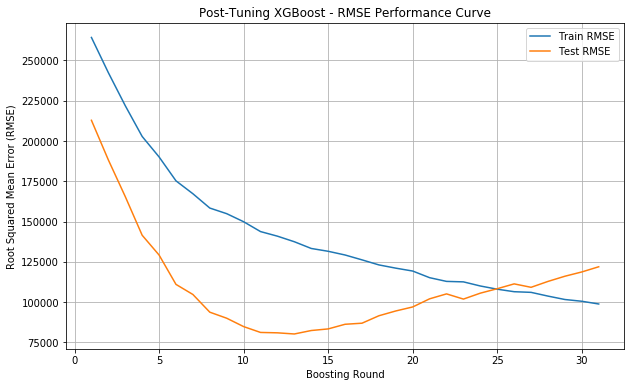

In [366]:
#Extract MAE values for both training and test sets
train_mae = pw_evals_result_1['Train']['mae']
test_mae = pw_evals_result_1['Test']['mae']


#Extract RMSE values for both training and test sets
train_rmse = pw_evals_result_1['Train']['rmse']
test_rmse = pw_evals_result_1['Test']['rmse']

# Create a plot to visualize the MAE performance curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_mae) + 1), train_mae, label='Train MAE' )
plt.plot(range(1, len(test_mae) + 1), test_mae, label='Test MAE' )
plt.xlabel('Boosting Round')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Post-Tuning XGBoost - MAE Performance Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_rmse) + 1), train_rmse, label='Train RMSE' )
plt.plot(range(1, len(test_rmse) + 1), test_rmse, label='Test RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('Root Squared Mean Error (RMSE)')
plt.title('Post-Tuning XGBoost - RMSE Performance Curve')
plt.legend()
plt.grid(True)

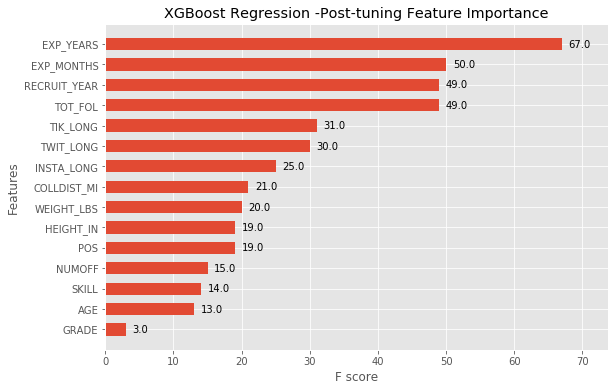

In [367]:


# Obtain the feature importance scores
importance_type = "weight"  # You can use "weight," "gain," or "cover"
importances = pw_model_1.get_score(importance_type=importance_type)

# Sort the features by importance in descending order
sorted_feature_names = sorted(importances, key=importances.get, reverse=True)

# Map sorted_feature_names to the corresponding feature names
mapped_feature_names = [feature_name[sorted_feature_names.index(name)] for name in sorted_feature_names]



mapped_feature_names
# # # Create a feature importance plot with actual feature names as y-axis labels
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111)
    xgb.plotting.plot_importance(pw_model_1, ax=ax, height=0.6, importance_type=importance_type)
    ax.set_yticklabels(mapped_feature_names)
    ax.set_title('XGBoost Regression -Post-tuning Feature Importance')

#go back and change when early stopping should happend  60???

**Evaluation** During boosting rounds, the model object has learned all the patterns of the training set. Perform testing.

In [402]:
preds1 = pretuned_model.predict(DM_test)

rmse = mean_squared_error(y_test, preds1, squared=False)

print(f"RMSE of the baseline param model: {rmse:.3f}")

mae = mean_absolute_error(y_test, preds1)
print(f"MAE of the baseline model: {mae:.3f}")


# Calculate the mean of the target variable in the test data
y_mean = np.mean(y_test)

# Calculate the total sum of squares (TSS)
TSS = np.sum((y_test - y_mean)**2)

# Calculate the residual sum of squares (RSS)
RSS = np.sum((y_test - preds1)**2)

# Calculate R-squared (R^2)
r_squared = 1 - (RSS / TSS)

print("R-squared (R^2) =", r_squared)


RMSE of the baseline param model: 207673.875
MAE of the baseline model: 62207.798
R-squared (R^2) = -0.19899808689862164


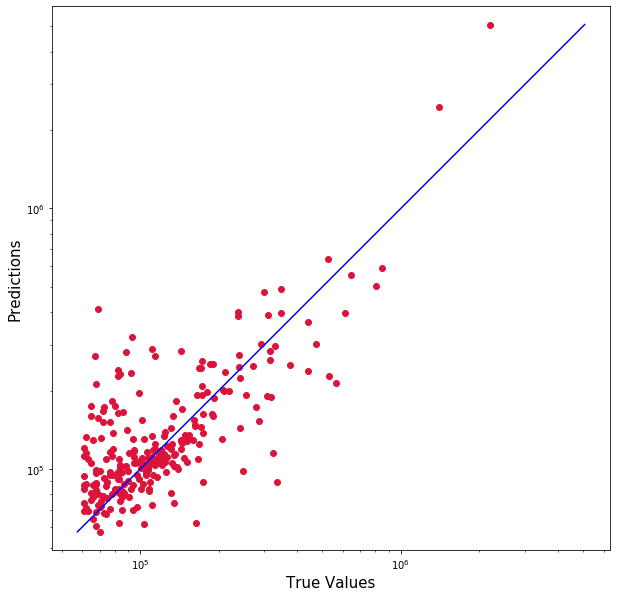

In [384]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, preds1, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(preds1), max(y_test))
p2 = min(min(preds1), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

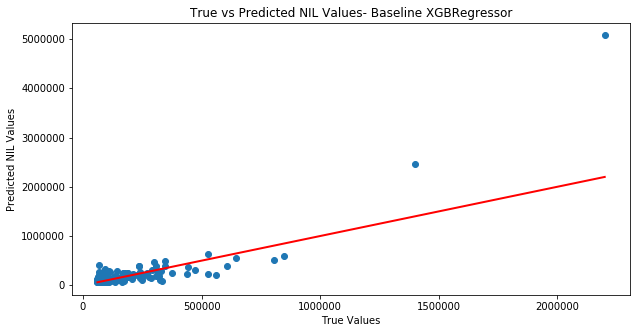

In [397]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, preds1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted NIL Values')
plt.title('True vs Predicted NIL Values- Baseline XGBRegressor')
plt.show()

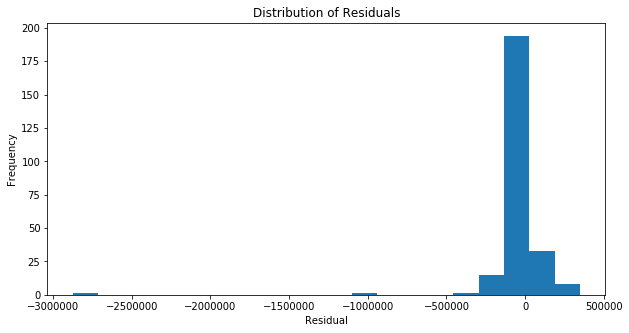

In [400]:
residuals = y_test - preds1

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [403]:
preds2 = pw_model_1.predict(DM_test)

rmse = mean_squared_error(y_test, preds2, squared=False)

print(f"RMSE of the tunedmodel: {rmse:.3f}")

mae = mean_absolute_error(y_test, preds2)
print(f"MAE of the tuned model: {mae:.3f}")


# Calculate the mean of the target variable in the test data
y_mean = np.mean(y_test)

# Calculate the total sum of squares (TSS)
TSS = np.sum((y_test - y_mean)**2)

# Calculate the residual sum of squares (RSS)
RSS = np.sum((y_test - preds2)**2)

# Calculate R-squared (R^2)
r_squared = 1 - (RSS / TSS)

print("R-squared (R^2) =", r_squared)




RMSE of the tunedmodel: 121975.068
MAE of the tuned model: 56555.190
R-squared (R^2) = 0.5863844191825721


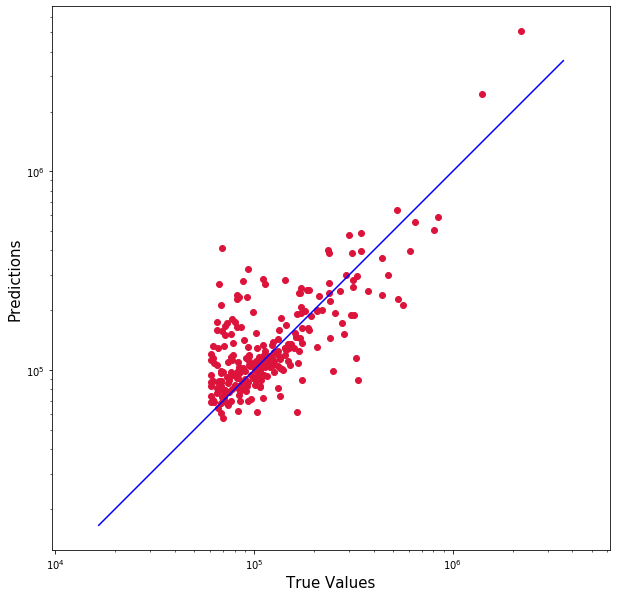

In [388]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, preds1, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(preds2), max(y_test))
p2 = min(min(preds2), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

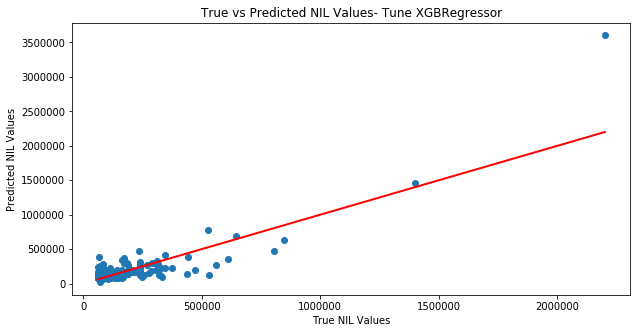

In [398]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, preds2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True NIL Values')
plt.ylabel('Predicted NIL Values')
plt.title('True vs Predicted NIL Values- Tune XGBRegressor')
plt.show()

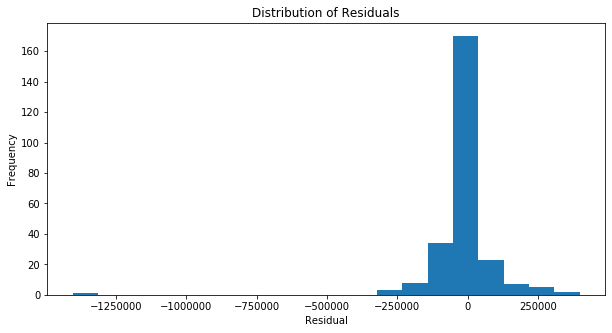

In [399]:
residuals = y_test - preds2

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()